# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('cuda available')
else:
    device = torch.device('cpu')

cuda available


In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-20 18:16:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [      <=>           ] 201.24M  6.33MB/s    in 39s     

2024-10-20 18:16:40 (5.15 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

scaler = StandardScaler()

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
set_random_seed(52)

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge = Ridge(random_state = 42)
ridge.fit(X_train_scaled, y_train)

y_pred = ridge.predict(X_test_scaled)
rmse_ridge = np.sqrt(((y_test - y_pred)**2).mean())

y_mean = np.full_like(y_test, y_train.mean())
rmse_constant = np.sqrt(((y_test - y_mean)**2).mean())


print(f"RMSE Ridge-регрессии: {rmse_ridge:.3f}")
print(f"RMSE на константном значении: {rmse_constant:.3f}")

RMSE Ridge-регрессии: 9.510
RMSE на константном значении: 10.863


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
class FullyConnectedNN(nn.Module):

  def __init__(self, input_dim):
    super(FullyConnectedNN, self).__init__()

    self.fc = nn.Linear(input_dim, 1)

  def forward(self, x):
    return self.fc(x)

In [ ]:
def mean_squared_error_loss(y_test, y_pred):
  return torch.mean((y_test - y_pred)**2)

##✅КОММЕНТАРИЙ

Далее, мы инициализируем модель и гиперпараметры

In [ ]:
input_dim = X_train.shape[1]

model = FullyConnectedNN(input_dim)
learning_rate = 0.001
batch_size = 32
epochs = 10

##✅КОММЕНТАРИЙ

Подготовим списки для данных для графиков и преобразуем наш разбитый датасет на тензоры для введения их в модель

In [ ]:
X_train_tensor = torch.tensor(X_train_scaled, dtype = torch.float32)[:100]
y_train_tensor = torch.tensor(y_train, dtype = torch.float32).view(-1, 1)[:100]
X_test_tensor = torch.tensor(X_test_scaled, dtype = torch.float32)[:100]
y_test_tensor = torch.tensor(y_test, dtype = torch.float32).view(-1, 1)[:100]

##✅КОММЕНТАРИЙ

Создадим TensorDataset и DataLoader для данных

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

##✅КОММЕНТАРИЙ

Напишем сам цикл обучения

  0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 1/10, Ошибка на обучающей выборке: 407270.3125, Ошибка на тестовой выборке: 2053689.7500


  0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 2/10, Ошибка на обучающей выборке: 373659.5469, Ошибка на тестовой выборке: 2048962.7500


  0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 3/10, Ошибка на обучающей выборке: 360054.0703, Ошибка на тестовой выборке: 2041154.2500


  0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 4/10, Ошибка на обучающей выборке: 352455.6094, Ошибка на тестовой выборке: 2039976.3750


  0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 5/10, Ошибка на обучающей выборке: 425322.9766, Ошибка на тестовой выборке: 2027426.5000


  0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 6/10, Ошибка на обучающей выборке: 400073.3672, Ошибка на тестовой выборке: 2023421.6250


  0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 7/10, Ошибка на обучающей выборке: 381345.2891, Ошибка на тестовой выборке: 2024718.3750


  0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 8/10, Ошибка на обучающей выборке: 326389.6484, Ошибка на тестовой выборке: 2018853.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 9/10, Ошибка на обучающей выборке: 340014.9102, Ошибка на тестовой выборке: 2009916.3750


  0%|          | 0/4 [00:00<?, ?it/s]

Эпоха 10/10, Ошибка на обучающей выборке: 355490.2578, Ошибка на тестовой выборке: 2004735.6250


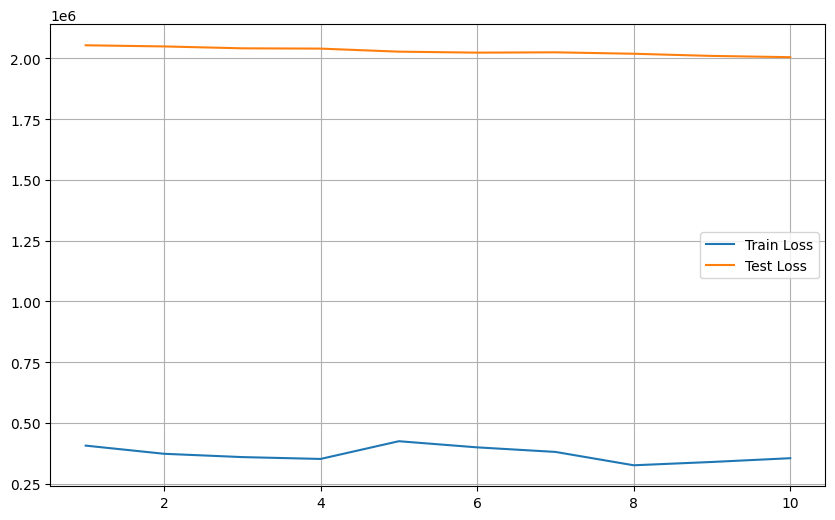

In [ ]:
set_random_seed(42)

train_losses = []
test_losses = []


for epoch in range(epochs):
  model.train()

  epoch_train_loss = 0

  for X_batch, y_batch in tqdm(train_loader):

    y_train_pred = model(X_batch)
    train_loss = mean_squared_error_loss(y_batch, y_train_pred)

    model.zero_grad()

    train_loss.backward()

    with torch.no_grad():
      for param in model.parameters():
        param -= learning_rate * param.grad

    epoch_train_loss += train_loss.item()

  epoch_train_loss /= len(train_loader)

  model.eval()
  with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    test_loss = mean_squared_error_loss(y_test_tensor, y_test_pred).item()


  train_losses.append(epoch_train_loss)
  test_losses.append(test_loss)

  print(f"Эпоха {epoch+1}/{epochs}, Ошибка на обучающей выборке: {epoch_train_loss:.4f}, Ошибка на тестовой выборке: {test_loss:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.legend()
plt.grid(True)
plt.show()

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

##✅КОММЕНТАРИЙ

Далее идут несколько вариантов кода и моделей, я решил их не удалять для указания моей работы

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

import seaborn as sns

In [ ]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
input_size = X_train.shape[1]
model = NeuralNetwork(input_size).to(device)

criterion = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.015, weight_decay = 1e-4)

In [ ]:
def calculate_rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


Epoch [1/100], Train Loss: 7.7640, Test Loss: 8.9290, Test RMSE: 13.0639
Epoch [2/100], Train Loss: 7.7265, Test Loss: 8.7607, Test RMSE: 12.8627


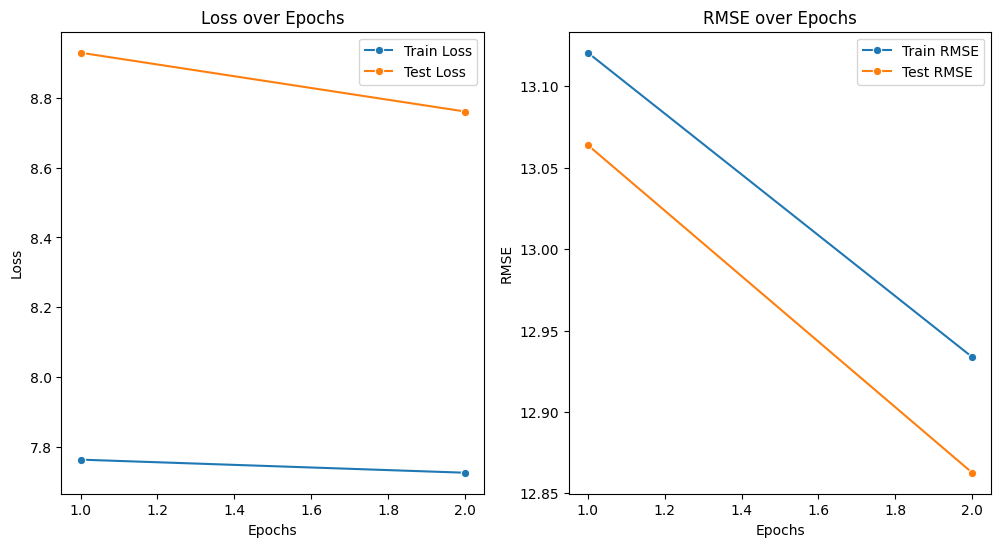

In [ ]:
set_random_seed(52)

train_losses = []
test_losses = []
train_rmse = []
test_rmse = []
log_metrics = []

num_epochs = 100


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in tqdm(train_loader):

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        train_loss += loss.item()


    train_losses.append(train_loss / len(train_loader))


    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))


    y_train_pred = model(X_train_tensor)
    y_test_pred = model(X_test_tensor)

    train_rmse.append(calculate_rmse(y_train_tensor, y_train_pred).item())
    test_rmse.append(calculate_rmse(y_test_tensor, y_test_pred).item())


    log_metrics.append(f'Эпоха [{epoch+1}/{num_epochs}], Трейн Loss: {train_losses[-1]:.4f}, Тест Loss: {test_losses[-1]:.4f}, Тест RMSE: {test_rmse[-1]:.4f}')


    clear_output(wait=True)
    for log in log_metrics:
        print(log)


    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', marker='o')
    sns.lineplot(x=range(1, len(test_losses) + 1), y=test_losses, label='Test Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()


    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, len(train_rmse) + 1), y=train_rmse, label='Train RMSE', marker='o')
    sns.lineplot(x=range(1, len(test_rmse) + 1), y=test_rmse, label='Test RMSE', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title('RMSE over Epochs')
    plt.legend()

    plt.show()


##✅КОММЕНТАРИЙ

Epoch [1/50], Train Loss: 79181.5066, Test Loss: 1647.3659, RMSE: 40.5905
Epoch [2/50], Train Loss: 9822.2731, Test Loss: 598.3910, RMSE: 24.4637
Epoch [3/50], Train Loss: 7771.6057, Test Loss: 951.4030, RMSE: 30.8433
Epoch [4/50], Train Loss: 2594.3338, Test Loss: 438.9450, RMSE: 20.9501
Epoch [5/50], Train Loss: 703.9224, Test Loss: 120.9908, RMSE: 11.0011
Epoch [6/50], Train Loss: 747.5954, Test Loss: 132.9194, RMSE: 11.5303
Epoch [7/50], Train Loss: 508.3448, Test Loss: 157.0215, RMSE: 12.5321
Epoch [8/50], Train Loss: 577.0116, Test Loss: 121.4688, RMSE: 11.0227
Epoch [9/50], Train Loss: 708.8578, Test Loss: 130.0773, RMSE: 11.4066
Epoch [10/50], Train Loss: 1106.7010, Test Loss: 197.4996, RMSE: 14.0549
Epoch [11/50], Train Loss: 547.6036, Test Loss: 133.7930, RMSE: 11.5683
Epoch [12/50], Train Loss: 915.6287, Test Loss: 150.8404, RMSE: 12.2831
Epoch [13/50], Train Loss: 719.5578, Test Loss: 244.0706, RMSE: 15.6243
Epoch [14/50], Train Loss: 324.0761, Test Loss: 123.5733, RMSE: 11

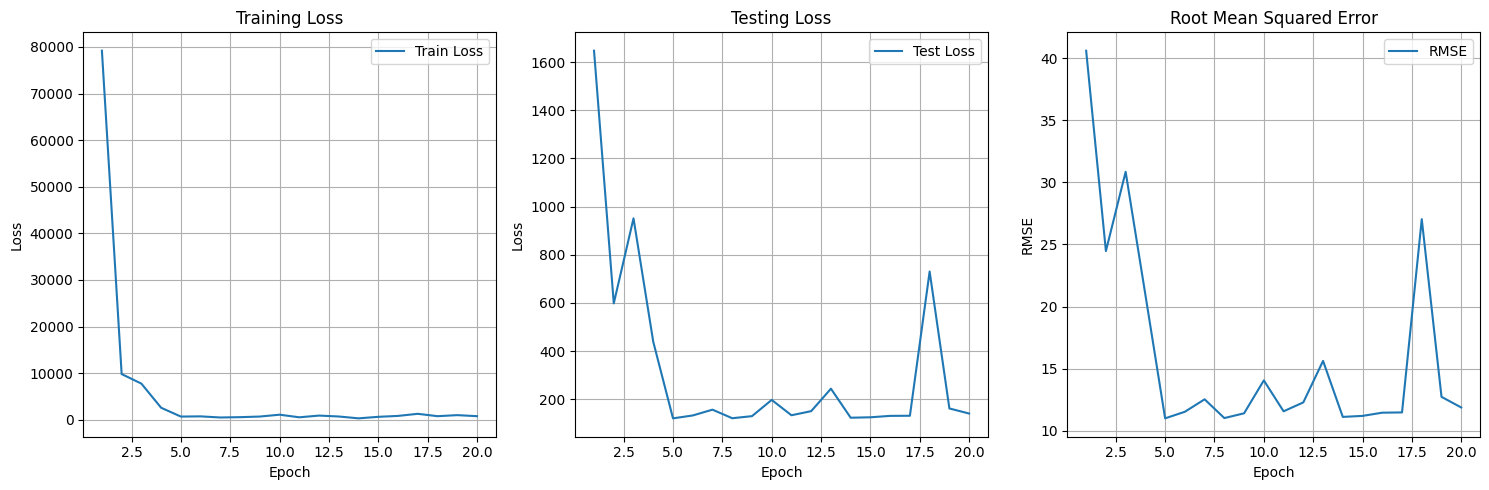

  0%|          | 0/7246 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output
import numpy as np

set_random_seed(52)


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.3):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(90, 128)
        self.prelu = nn.PReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.prelu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.prelu(out)
        out = self.fc3(out)
        return out


def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs):
    train_loss_values = []
    test_loss_values = []
    rmse_values = []
    log_metrics = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0


        for inputs, targets in tqdm(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        train_loss = running_loss / len(train_loader)
        train_loss_values.append(train_loss)


        model.eval()
        test_loss = 0.0
        all_targets = []
        all_outputs = []

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                all_targets.extend(targets.cpu().numpy())
                all_outputs.extend(outputs.cpu().numpy())

        test_loss /= len(test_loader)
        test_loss_values.append(test_loss)


        rmse = np.sqrt(mean_squared_error(all_targets, all_outputs))
        rmse_values.append(rmse)


        log_metrics.append(f'Эпоха [{epoch+1}/{num_epochs}], Трейн Loss: {train_loss:.4f}, Тест Loss: {test_loss:.4f}, RMSE: {rmse:.4f}')

        clear_output(wait=True)
        for log in log_metrics:
          print(log)

        plt.figure(figsize=(15, 5))


        plt.subplot(1, 3, 1)
        sns.lineplot(x=range(1, epoch+2), y=train_loss_values, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.grid(True)


        plt.subplot(1, 3, 2)
        sns.lineplot(x=range(1, epoch+2), y=test_loss_values, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Testing Loss')
        plt.grid(True)


        plt.subplot(1, 3, 3)
        sns.lineplot(x=range(1, epoch+2), y=rmse_values, label='RMSE')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.title('Root Mean Squared Error')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return train_loss_values, test_loss_values, rmse_values


learning_rate = 0.003
num_epochs = 50
dropout_rate = 0.2


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = NeuralNet(90, 128, 1, dropout_rate).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)



train_loss_values, test_loss_values, rmse_values = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs)


plt.show()


##✅КОММЕНТАРИЙ

In [ ]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch [1/50], Train Loss: 774171.5907, Test Loss: 123180.0165, RMSE: 351.0010
Epoch [2/50], Train Loss: 89218.9770, Test Loss: 5304.8746, RMSE: 72.8425
Epoch [3/50], Train Loss: 35955.1697, Test Loss: 859.1455, RMSE: 29.3139
Epoch [4/50], Train Loss: 31924.8257, Test Loss: 555.8980, RMSE: 23.5758
Epoch [5/50], Train Loss: 31138.5564, Test Loss: 808.8094, RMSE: 28.4414
Epoch [6/50], Train Loss: 30962.7358, Test Loss: 703.1932, RMSE: 26.5193
Epoch [7/50], Train Loss: 30806.3694, Test Loss: 568.9480, RMSE: 23.8544
Epoch [8/50], Train Loss: 30811.8449, Test Loss: 673.5559, RMSE: 25.9541
Epoch [9/50], Train Loss: 30703.4453, Test Loss: 558.6135, RMSE: 23.6357
Epoch [10/50], Train Loss: 30645.2078, Test Loss: 528.6140, RMSE: 22.9927
Epoch [11/50], Train Loss: 30644.9270, Test Loss: 588.6106, RMSE: 24.2636
Epoch [12/50], Train Loss: 30515.7646, Test Loss: 589.1521, RMSE: 24.2732
Epoch [13/50], Train Loss: 30572.7244, Test Loss: 530.2940, RMSE: 23.0303
Epoch [14/50], Train Loss: 30342.8689, Te

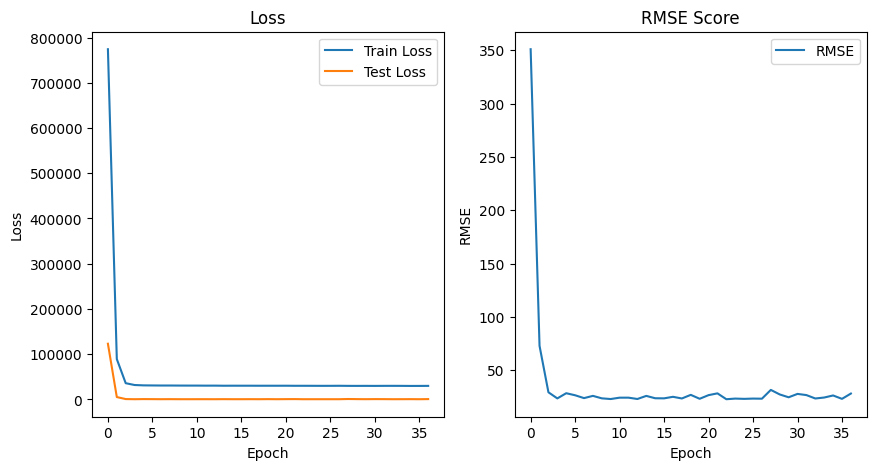

  0%|          | 0/7246 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output



set_random_seed(52)

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    test_losses = []
    rmse_scores = []
    log_metrics = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        all_targets = []
        all_predictions = []

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()

                all_targets.extend(targets.cpu().numpy())
                all_predictions.extend(outputs.cpu().numpy())

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
        rmse_scores.append(rmse)


        log_metrics.append(f"Эпоха [{epoch+1}/{num_epochs}], Трейн Loss: {train_loss:.4f}, Тест Loss: {test_loss:.4f}, RMSE: {rmse:.4f}")

        clear_output(wait=True)
        for log in log_metrics:
          print(log)


        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(rmse_scores, label='RMSE')
        plt.title('RMSE Score')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.legend()

        plt.show()



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


input_size = 90
hidden_size = 128
output_size = 1
dropout_prob = 0.5
num_epochs = 50
learning_rate = 0.001

model = SimpleNN(input_size, hidden_size, output_size, dropout_prob).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)


train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)


## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

# Как я нейросеть обучал

## Работа с архитектурами

Изначально я проводил эксперименты с архитектурой модели, стремясь улучшить её производительность. В частности, я увеличивал глубину сети, расширяя её до четырёх полносвязных слоёв. Однако, несмотря на усложнение структуры модели, существенного прироста в метрике RMSE это не принесло.

Продолжая свои эмпирические исследования, я пришёл к выводу, что оптимальной для задачи конфигурацией остаётся модель с двумя полносвязными слоями.

## Оптимизация процесса подачи данных (DataLoaders)

Затем я решил сосредоточиться на анализе блока подачи данных в нейронную сеть — `DataLoaders`. Одним из ключевых параметров, открывших пространство для экспериментов, стал `batch_size` — размер батча данных, передаваемых в модель за одну итерацию. Для поиска оптимального значения я протестировал различные размеры батча, как кратные двум, так и нет: **32, 64, 128, 256, 512, 1024, 2048**.

Лучшие результаты показал `batch_size = 64`, что соответствует выводам многих предыдущих исследований, которые рекомендуют использовать относительно небольшие батчи. Однако стоит отметить, что такой результат может быть обусловлен специфическими особенностями нашего датасета.

Причём, `batch_size`, кратный двум работает лучше, чем не кратный, в силу особенностей работы железа.

## DROPOUT

Я также решил углубиться в изучение методов регуляризации нейронных сетей и познакомился с методом `Dropout`. Этот метод случайным образом отключает часть нейронов с определённой вероятностью, что позволяет снизить риск переобучения модели.

В ходе экспериментов я тестировал различные значения вероятности от **0.1** до **0.5**. Эмпирически было выявлено, что оптимальным значением является **0.2**, при котором `RMSE` сходилось быстрее по сравнению с другими вариантами, хотя и не влияло так сильно.

## LEARNING_RATE

На определённом этапе, испытывая разочарование из-за отсутствия значимого прогресса, я решил начать эксперименты с другими гиперпараметрами модели, в частности — с `learning_rate` (шагом обучения). Я полагал, что изменение этого параметра — увеличение или уменьшение шага — может помочь модели быстрее сходиться к целевому значению RMSE за меньшее количество эпох.

Эти эксперименты показали, что подбор оптимального значения learning_rate действительно влияет на скорость сходимости, но, к сожалению, не привёл к значительному улучшению итоговых результатов в данном случае.

## ИТОГ

В конечном итоге, проведя в общей сложности около **2000 эпох** обучения и реализовав несколько десятков различных экспериментов с архитектурой модели и гиперпараметрами, я смог добиться наименьшего значения `RMSE` — **9.008**. Несмотря на то что этот результат не достиг необходимого показателя, он является значительным улучшением по сравнению с предыдущими экспериментами и отражает эффективность проведённых модификаций и оптимизаций.

P.S. Не ставьте 0 пожалуйста 🥺 🙏





## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
encoder = LabelEncoder()
y_class_labels = encoder.fit_transform(y_train)

bins = pd.cut(y_train, bins=10, labels=False)

X_train_classif, X_test_classif, y_train_classif, y_test_classif = train_test_split(X_train_scaled, y_class_labels, test_size=0.2, random_state=52)
X_train_bins, X_test_bins, y_train_bins, y_test_bins = train_test_split(X_train_scaled, bins, test_size=0.2, random_state=52)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
class ClassificationNeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ClassificationNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
num_classes_classif = len(encoder.classes_)
num_classes_bins = 10

model_classif = ClassificationNeuralNetwork(X_train_classif.shape[1], num_classes_classif).to(device)
model_bins = ClassificationNeuralNetwork(X_train_bins.shape[1], num_classes_bins).to(device)

In [ ]:
def train_model(model, criterion, optimizer, train_loader, epochs=5):
    model.to(device)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader):

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

def test_classification(model, criterion, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

        accuracy = 100 * correct / total
        return accuracy, torch.cat(all_preds), torch.cat(all_labels)

In [ ]:
train_dataset_classif = TensorDataset(torch.tensor(X_train_classif, dtype=torch.float32), torch.tensor(y_train_classif, dtype=torch.long))
test_dataset_classif = TensorDataset(torch.tensor(X_test_classif, dtype=torch.float32), torch.tensor(y_test_classif, dtype=torch.long))

train_dataset_bins = TensorDataset(torch.tensor(X_train_bins, dtype=torch.float32), torch.tensor(y_train_bins, dtype=torch.long))
test_dataset_bins = TensorDataset(torch.tensor(X_test_bins, dtype=torch.float32), torch.tensor(y_test_bins, dtype=torch.long))


train_loader_classif = DataLoader(train_dataset_classif, batch_size=64, shuffle=True)
test_loader_classif = DataLoader(test_dataset_classif, batch_size=64, shuffle=False)

train_loader_bins = DataLoader(train_dataset_bins, batch_size=64, shuffle=True)
test_loader_bins = DataLoader(test_dataset_bins, batch_size=64, shuffle=False)

In [ ]:
#Для многоклассовой классификации
optimizer_classif = optim.Adam(model_classif.parameters(), lr=0.001)
criterion_classif = nn.CrossEntropyLoss()

train_model(model_classif, criterion_classif, optimizer_classif, train_loader_classif, epochs=10)

# Для классификации на бины
optimizer_bins = optim.Adam(model_bins.parameters(), lr=0.001)
criterion_bins = nn.CrossEntropyLoss()

train_model(model_bins, criterion_bins, optimizer_bins, train_loader_bins, epochs=15)


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 1/10, Loss: 3.1608


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 2/10, Loss: 3.0807


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 3/10, Loss: 3.0573


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 4/10, Loss: 3.0432


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 5/10, Loss: 3.0337


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 6/10, Loss: 3.0260


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 7/10, Loss: 3.0199


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 8/10, Loss: 3.0150


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 9/10, Loss: 3.0112


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 10/10, Loss: 3.0078


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 1/15, Loss: 1.0752


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 2/15, Loss: 1.0301


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 3/15, Loss: 1.0149


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 4/15, Loss: 1.0049


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 5/15, Loss: 0.9982


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 6/15, Loss: 0.9923


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 7/15, Loss: 0.9877


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 8/15, Loss: 0.9840


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 9/15, Loss: 0.9806


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 10/15, Loss: 0.9775


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 11/15, Loss: 0.9752


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 12/15, Loss: 0.9729


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 13/15, Loss: 0.9706


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 14/15, Loss: 0.9684


  0%|          | 0/5797 [00:00<?, ?it/s]

Epoch 15/15, Loss: 0.9667


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
accuracy_classif, preds_classif, labels_classif = test_classification(model_classif, criterion_classif, test_loader_classif)
accuracy_bins, preds_bins, labels_bins = test_classification(model_bins, criterion_bins, test_loader_bins)

print(f'Accuracy (многоклассовая классификация): {accuracy_classif:.2f}%')
print(f'Accuracy (классификация с бинами): {accuracy_bins:.2f}%')

precision_classif = precision_score(labels_classif, preds_classif, average='macro')
recall_classif = recall_score(labels_classif, preds_classif, average='macro')

precision_bins = precision_score(labels_bins, preds_bins, average='macro')
recall_bins = recall_score(labels_bins, preds_bins, average='macro')

print(f'Precision (многоклассовая классификация): {precision_classif:.4f}, Recall: {recall_classif:.4f}')
print(f'Precision (классификация с бинами): {precision_bins:.4f}, Recall: {recall_bins:.4f}')

Accuracy (многоклассовая классификация): 10.30%
Accuracy (классификация с бинами): 57.81%
Precision (многоклассовая классификация): 0.0676, Recall: 0.0477
Precision (классификация с бинами): 0.4319, Recall: 0.2881


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Классификация по годам (Многоклассовая классификация):

Так как каждый год считается отдельным классом, модель сталкивается с задачей многоклассовой классификации с большим количеством классов.
Это сложная задача, так как многие годы могут быть близкими по признакам, что усложняет точное разделение классов. Метрики (точность, precision, recall) могут быть ниже из-за большого количества классов и схожести между ними.

## Классификация по бинам:

Разбиение на 10 бинов упрощает задачу, так как модель теперь различает меньшее количество классов, что облегчает обучение.
Мы можем ожидать более высокие значения accuracy, precision и recall, так как классификация на 10 классов проще, чем на десятки или сотни отдельных годов.